# Malware detection

A toy dataset for malware detection. It contains only two classes (benign and malware).

This notebook will address the topic of feature importance and feature selection.

In [15]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import os
# 1. Setup JAX Backend
os.environ["KERAS_BACKEND"] = "jax"

import jax
import keras
from keras import layers
from keras import Model


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]

In [16]:
df = pl.read_csv('../../datasets/malware_dataset.csv.gz')
df.head()

hash,millisecond,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""42fb5e2ec009a05ff5143227297074…",0,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",1,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",2,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",3,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",4,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0


In [17]:
mapping = {'benign':0, 'malware':1}
df = df.with_columns(pl.col('classification').replace(mapping).cast(pl.Int32, strict=False).alias('classification'))

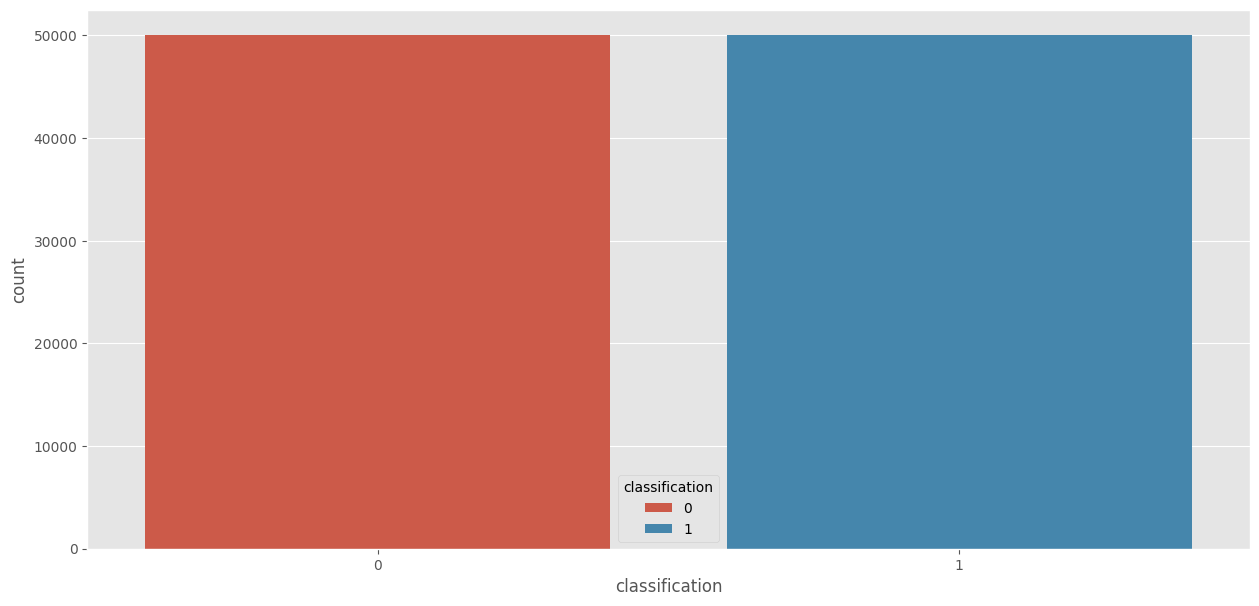

In [18]:
sns.countplot(data=df, x='classification', hue='classification')
plt.show()

In [19]:
df = df.drop(['hash', 'millisecond'])
df.describe()

statistic,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,0.0,3.0697e9,18183.90007,0.0,0.0,0.0,15312.73951,0.0,0.0,9.58777,728.46543,8771.13948,0.0,266.49112,117.92024,127.67815,205.32485,0.0,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,3.2044e9,385415.45197,4.05931,1.66142,0.0,0.0
"""std""",0.500003,936172.583333,0.0,296306.144182,4609.792765,0.0,0.0,0.0,3256.475008,0.0,0.0,46.504908,84.475361,3785.30516,0.0,311.996779,3.116892,22.277995,112.717875,0.0,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,0.0,10144.036494,0.822848,3.26304,0.0,0.0
"""min""",0.0,0.0,0.0,3.0692e9,13988.0,0.0,0.0,0.0,9695.0,0.0,0.0,0.0,612.0,2588.0,0.0,4.0,112.0,92.0,29.0,0.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,3.2044e9,371782.0,3.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,3.0695e9,14352.0,0.0,0.0,0.0,12648.0,0.0,0.0,0.0,651.0,6428.0,0.0,99.0,114.0,112.0,112.0,0.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,3.2044e9,378208.0,3.0,0.0,0.0,0.0
"""50%""",1.0,0.0,0.0,3.0697e9,16159.0,0.0,0.0,0.0,15245.0,0.0,0.0,1.0,725.0,7865.0,0.0,177.0,120.0,127.0,193.0,0.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,3.2044e9,383637.0,4.0,0.0,0.0,0.0
"""75%""",1.0,4096.0,0.0,3.0700e9,22182.0,0.0,0.0,0.0,17663.0,0.0,0.0,4.0,785.0,10684.0,0.0,327.0,120.0,138.0,273.0,0.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,3.2044e9,390324.0,5.0,1.0,0.0,0.0
"""max""",1.0,4.3266048e7,0.0,3.0702e9,31855.0,0.0,0.0,0.0,27157.0,0.0,0.0,515.0,995.0,28184.0,0.0,2810.0,120.0,196.0,755.0,0.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,3.2044e9,421913.0,7.0,15.0,0.0,0.0


## Drop columns with low variance

In [20]:
threshold = 0.5
df = df.drop([col.name for col in df.select(pl.all().std() < threshold) if col.item()])
df.describe()

statistic,classification,state,prio,static_prio,vm_truncate_count,free_area_cache,mm_users,map_count,total_vm,shared_vm,exec_vm,reserved_vm,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,utime,stime,gtime
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,3.0697e9,18183.90007,15312.73951,9.58777,728.46543,8771.13948,266.49112,117.92024,127.67815,205.32485,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,385415.45197,4.05931,1.66142
"""std""",0.500003,936172.583333,296306.144182,4609.792765,3256.475008,46.504908,84.475361,3785.30516,311.996779,3.116892,22.277995,112.717875,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,10144.036494,0.822848,3.26304
"""min""",0.0,0.0,3.0692e9,13988.0,9695.0,0.0,612.0,2588.0,4.0,112.0,92.0,29.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,371782.0,3.0,0.0
"""25%""",0.0,0.0,3.0695e9,14352.0,12648.0,0.0,651.0,6428.0,99.0,114.0,112.0,112.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,378208.0,3.0,0.0
"""50%""",1.0,0.0,3.0697e9,16159.0,15245.0,1.0,725.0,7865.0,177.0,120.0,127.0,193.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,383637.0,4.0,0.0
"""75%""",1.0,4096.0,3.0700e9,22182.0,17663.0,4.0,785.0,10684.0,327.0,120.0,138.0,273.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,390324.0,5.0,1.0
"""max""",1.0,4.3266048e7,3.0702e9,31855.0,27157.0,515.0,995.0,28184.0,2810.0,120.0,196.0,755.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,421913.0,7.0,15.0


## Split the data

In [21]:
Y = df['classification'].to_numpy()
X = df.drop(['classification']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

X.shape

(100000, 21)

In [23]:
def create_model(input_shape):
    nn = keras.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(32, kernel_initializer='glorot_uniform', activation="relu"),
    keras.layers.Dense(16, kernel_initializer='glorot_uniform', activation="relu"),
    keras.layers.Dense(1, kernel_initializer='glorot_uniform', activation="sigmoid")])
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

create_model((X.shape[1],)).summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from scikeras.wrappers import KerasClassifier

clf = KerasClassifier(model=create_model((X.shape[1],)), verbose=0, epochs=10, batch_size=128)

# fit the model
clf.fit(X_train, y_train)

,model,"<Sequential n...4, built=True>"
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,128
,validation_batch_size,None
,verbose,0
,callbacks,None


In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



## Using Keras Directly

In [ ]:
# create model
nn = models.Sequential()

nn.add(layers.Dense(16, input_dim=X.shape[1], kernel_initializer='glorot_uniform', activation="relu"))
nn.add(layers.Dense(8, kernel_initializer='glorot_uniform', activation="relu"))
nn.add(layers.Dense(1, kernel_initializer='glorot_uniform', activation="sigmoid"))

nn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

nn.summary()

/home/mantunes/git/aas/venv/lib64/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8777 - loss: 0.2988 - val_accuracy: 0.9958 - val_loss: 0.0300
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9940 - loss: 0.0246 - val_accuracy: 0.9970 - val_loss: 0.0134
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9969 - loss: 0.0107 - val_accuracy: 0.9980 - val_loss: 0.0079
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9981 - loss: 0.0078 - val_accuracy: 0.9990 - val_loss: 0.0044
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9987 - loss: 0.0059 - val_accuracy: 0.9991 - val_loss: 0.0040
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9993 - val_loss: 0.0020
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9994 - loss: 0.0031 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


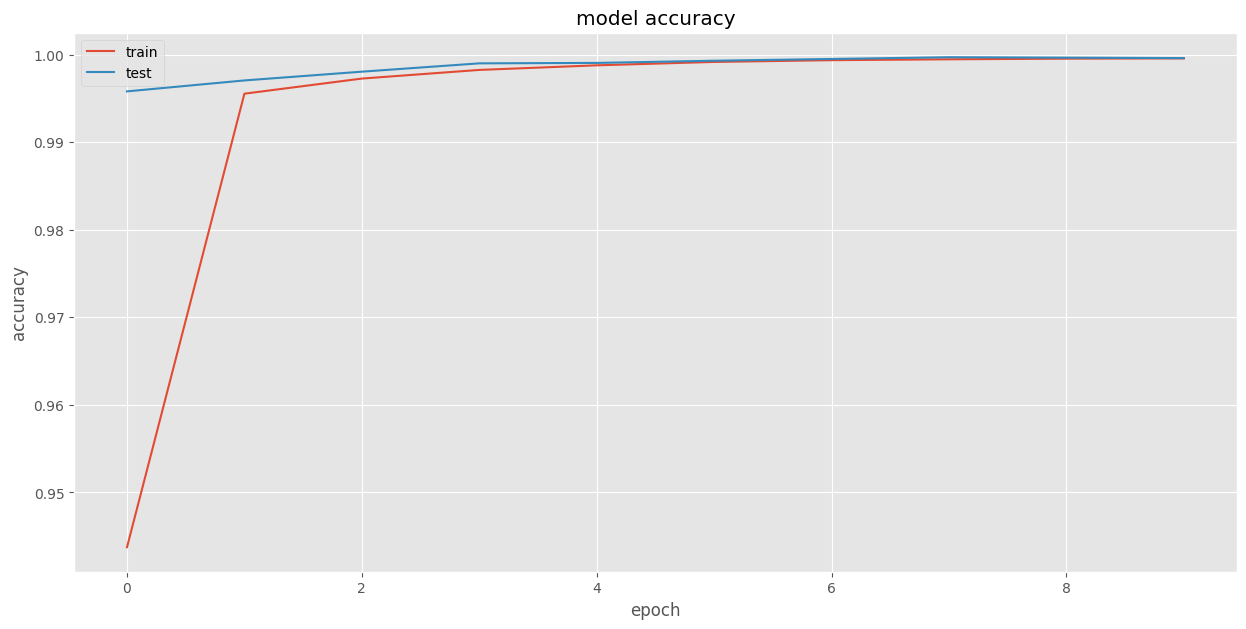

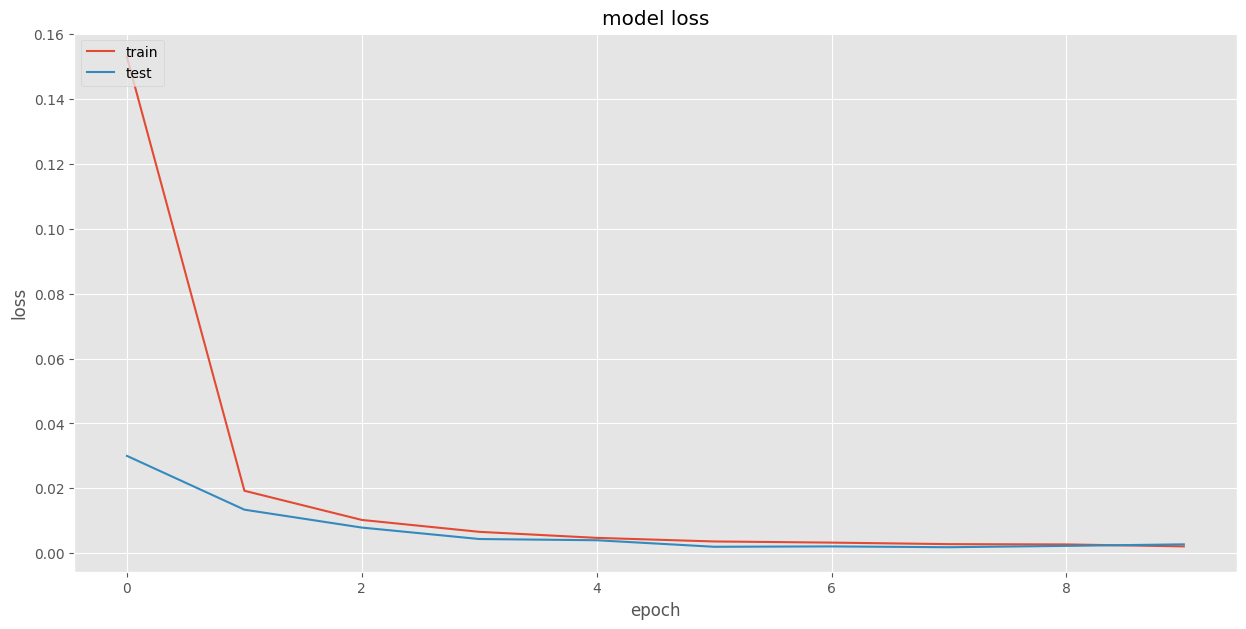

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()